<a href="https://colab.research.google.com/github/Pepcoders/Data-Science-December/blob/main/22-05-11-Pytorch-GAN/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/docs/stable/index.html

In [2]:
! pip3 install torch torchvision torchaudio

In [1]:
import torch
import numpy as np

# Numpy interoperatiblity

In [2]:
a = torch.tensor([1,2,3])
a

tensor([1, 2, 3])

In [3]:
print(a.size())

torch.Size([3])


In [4]:
b = torch.tensor([
           [1,2,3],
           [5,6,7]
])
print(b.shape)

torch.Size([2, 3])


In [5]:
b[0, :2].clone()

tensor([1, 2])

In [6]:
a = torch.ones(3,5)

In [7]:
a.numpy()

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [8]:
b = np.array([5,3,6,7])
torch.from_numpy(b)

tensor([5, 3, 6, 7])

# Cpu Gpu

In [12]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [13]:
device

'cuda'

In [14]:
a_gpu = torch.tensor([1,2,3], device=device)

In [15]:
a_gpu

tensor([1, 2, 3], device='cuda:0')

In [18]:
a_cpu = a_gpu.to('cpu')

In [19]:
a_cpu.to('cuda')

tensor([1, 2, 3], device='cuda:0')

# Save Tensor

In [20]:
a = torch.tensor([1,3,45,6], device=device)

In [21]:
torch.save(a, 'a_tensor.t')

In [22]:
b=torch.load('a_tensor.t')
b

tensor([ 1,  3, 45,  6], device='cuda:0')

# DataSet

In [23]:
from torchvision import datasets

In [26]:
df_train = datasets.CIFAR10('./datasets', train=True, download=True)

Files already downloaded and verified


In [27]:
df_val = datasets.CIFAR10('./datasets', train=False, download=True)

Files already downloaded and verified


In [32]:
import matplotlib.pyplot as plt


In [34]:
img, label = df_train[1]

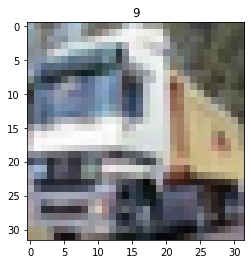

In [35]:
plt.imshow(img)
plt.title(label)
plt.show()

In [37]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

In [38]:
img_t.shape

torch.Size([3, 32, 32])

In [45]:
a = torch.transpose(img_t, 0, 1)
a = torch.transpose(a, 1, 2)
a.shape

torch.Size([32, 32, 3])

In [46]:
df_train = datasets.CIFAR10('./datasets', train=True, download=True, transform=to_tensor)

Files already downloaded and verified


In [50]:
img, label = df_train[0]
type(img), type(label)

(torch.Tensor, int)

# DCGAN

In [51]:
import os
import torch
import matplotlib.pyplot as plt
from IPython import display
import time
from tqdm import tqdm

In [52]:
DATASET_ROOT = 'dataset/'
CHECKPOINT_GEN = 'gen.pth.tar'
CHECKPOINT_DISC = 'disc.pth.tar'
LEARNING_RATE = 2e-4

LOAD_MODEL = os.path.exists(CHECKPOINT_GEN) and os.path.exists(CHECKPOINT_DISC)
SAVE_MODEL = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
import torch


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint at", filename)
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint from", checkpoint_file)
    checkpoint = torch.load(checkpoint_file, map_location=device)
    # model.load_state_dict(checkpoint)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## Discriminator \ Generator Model

In [57]:
from audioop import bias
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # N x channel_img x 64 x 64
            # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(
                channels_img, features_d, 4, 2, 1
            ),
            nn.LeakyReLU(0.2),

            self._block(features_d, features_d*2, 4, 2, 1), # 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # 8x8
            self._block(features_d*4, features_d*8, 4, 2, 1), # 4x4
            nn.Conv2d(features_d*8, 1, 4, 2, 0), # 1 x 1
            nn.Sigmoid(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False, # because we have used BatchNorm
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # N * z_dim * 1 * 1
            self._block(z_dim, features_g*16, 4, 1, 0), # n f_G*16 4 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16x16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32x32
            nn.ConvTranspose2d(
                features_g*2,
                channels_img,
                4,
                2,
                1
            ),
            nn.Tanh(), # output [-1, 1]
        )
    
    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
# torch.nn.init.xavier_uniform(conv1.weight)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    init_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    init_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print('Success Test')

test()

Success Test


In [58]:
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

In [59]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
init_weights(gen)
init_weights(disc)

In [60]:
from locale import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Tutorial dataset
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5]*CHANNELS_IMG, [0.5]*CHANNELS_IMG 
    ),
])

dataset = datasets.MNIST(root=DATASET_ROOT, train=True, transform=transform,download=True)
# dataset = datasets.ImageFolder(root=DATASET_ROOT, train=True, transform=transform)

loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f'logs/real')
writer_fake = SummaryWriter(f'logs/fake')
step = 0

gen.train()
disc.train()

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN,
        gen,
        opt_gen,
        LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISC,
        disc,
        opt_disc,
        LEARNING_RATE,
    )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



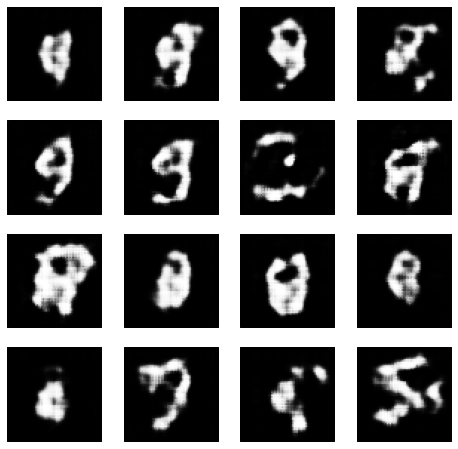

443it [07:33,  1.02s/it]


KeyboardInterrupt: ignored

In [61]:
# Perform BackProp
# https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

for epoch in range(NUM_EPOCHS):
    start = time.time()
    print('\nEpoch', epoch+1, '/', NUM_EPOCHS)
    for batch_idx, (real, _) in tqdm(enumerate(loader)):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, NOISE_DIM, 1, 1)).to(device)
        fake = gen(noise)

        # train Discrimanator
        disc_real = disc(real).reshape(-1)
        disc_fake = disc(fake).reshape(-1)
        
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake)/2

        # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
        disc.zero_grad()
        loss_disc.backward(retain_graph=True) # gradients calculate
        opt_disc.step() # update weights

        # train Generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # print('.', end='', flush=True)

        if batch_idx%50 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

        if batch_idx % 50 == 0:
            display.clear_output(wait=True)
            predictions = gen(fixed_noise)
            predictions = predictions.detach().cpu().numpy()


            fig = plt.figure(figsize=(8, 8))
            for i in range(min(16, predictions.shape[0])):
                plt.subplot(4, 4, i+1)
                plt.imshow(predictions[i, 0, :, :] * 127.5 + 127.5, cmap='gray')
                plt.axis('off')
                
            plt.savefig('image_at_epoch_{:04d}.png'.format(step))
            plt.show()
        
            step += 1
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    if SAVE_MODEL:
        save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

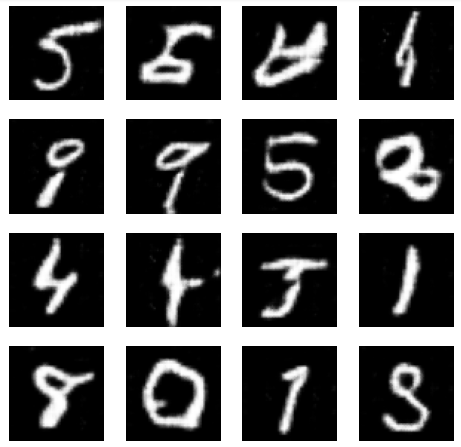

In [62]:
# To generate GIFs
!pip install imageio
# !pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xbxl9m4b
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-xbxl9m4b
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=df0d181987730b400635e638f129df94083c8e7bf574065b1653faaa7738343d
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmcu_eel/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [63]:
import imageio
import glob

In [64]:
anim_file = 'dcgan_MNIST.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image_at_epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)